<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-MongoDB-Connection" data-toc-modified-id="Setup-MongoDB-Connection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup MongoDB Connection</a></span></li><li><span><a href="#Creating-a-dataframe-of-Manhattan-Buildings-(from-MongoDB)" data-toc-modified-id="Creating-a-dataframe-of-Manhattan-Buildings-(from-MongoDB)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Creating a dataframe of Manhattan Buildings (from MongoDB)</a></span></li></ul></div>

# K-Means Clustering of NYC Pluto Data
April 4th

## Setup MongoDB Connection

In [16]:
#load python dependencies
import pandas as pd
import pprint as pp
import json
import string
from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import math
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#connect to mongodb
from pymongo import MongoClient
client = MongoClient()
db = client.thesis #thesis is the name of the DB we want to access

In [3]:
# get the names of collections in MongoDB
db.collection_names(include_system_collections=False)

['buildings',
 'buildings_with_lots2',
 'buildings_with_lots',
 'lots_with_buffer',
 'green_roofs']

In [4]:
buildings = db.buildings

In [12]:
# spatial join test for 1 building
for doc in buildings.find(
    {
        "geometry": {
            "$geoWithin": {
                "$geometry" : {
                    "type" : "Polygon",
                     "coordinates" : [[[-74.00357149780405, 40.739750787571296],
                                       [-74.0032138954338,40.739665780439516],
                                       [-74.00320789710163,40.73966326774744],
                                       [-74.00320302205861,40.73965896338152],
                                       [-74.00319978576269,40.73965332245971],
                                       [-74.00319853040044,40.73964694141936],
                                       [-74.00319938870638,40.73964049495356],
                                       [-74.00320226992835,40.739634664673105],
                                       [-74.003246500287,40.739573008751414],
                                       [-74.00329109205792,40.73951084620651],
                                       [-74.00333404285205,40.73945097146967],
                                       [-74.00338030113019,40.73938648904522],
                                       [-74.00342944759335,40.73931797523731],
                                       [-74.00343423237918,40.739313246099265],
                                       [-74.00344031457,40.73931037105544],
                                       [-74.0034470059823,40.739309675409295],
                                       [-74.00345354950082,40.73931123787133],
                                       [-74.00384894205064,40.73947998532931],
                                       [-74.0038540011946,40.73948310469541],
                                       [-74.00385792023364,40.73948757308611],
                                       [-74.00386035306389,40.73949299588239],
                                       [-74.00386108483369,40.73949889417837],
                                       [-74.00386005091791,40.739504747075145],
                                       [-74.00385734262522,40.73951003768317],
                                       [-74.00367437802153,40.739765098595996],
                                       [-74.00367015922609,40.7397694166797],
                                       [-74.00366484415729,40.73977227921798],
                                       [-74.00365891707212,40.739773425404394],
                                       [-74.00365291798853,40.739772750809664],
                                       [-74.00357149780405,40.739750787571296]]]
                }
            }
        }
    }
):
    pp.pprint(doc)
    

{'_id': ObjectId('5ad118e98ebfd6b85610509d'),
 'geometry': {'coordinates': [[[-74.00339983290745, 40.73940048154231],
                               [-74.00340650854376, 40.739391313279995],
                               [-74.00341807222367, 40.739375430689684],
                               [-74.00342963234664, 40.73935955350131],
                               [-74.00343501167893, 40.739352164678394],
                               [-74.00358002094784, 40.7394132461763],
                               [-74.00359789020935, 40.73942077296012],
                               [-74.00359230963855, 40.73942843735214],
                               [-74.00355702913141, 40.739476894745856],
                               [-74.00355608206651, 40.73947819510768],
                               [-74.00355819422352, 40.739479084743664],
                               [-74.00361921593162, 40.739504787823364],
                               [-74.00364594443116, 40.73946807599871],
             

In [5]:
# Specify fields wanted
fields = {"properties.Borough" : 1,
            "properties.Address" : 1,
              "properties.BldgArea" : 1,
              "properties.BldgClass" : 1,
              "properties.Block" : 1,
              "properties.BoroCode" : 1,
              "properties.LandUse" : 1,
              "properties.LotArea" : 1,
              "properties.NumFloors" : 1,
              "properties.UnitsRes" : 1,
              "properties.UnitsTotal" : 1 ,
              "properties.OwnerName" : 1,
              "properties.YearBuilt": 1,
              "properties.CD" : 1,
              "properties.ResidFAR": 1,
              "properties.FacilFAR": 1, 
              "properties.BuiltFAR": 1,
              "properties.CommFAR": 1,
              "properties.Landmark": 1,
              "properties.UnitsTotal": 1,
              "properties.AssessTot": 1
          
         }
            

In [5]:
buildings.find_one({})

{'_id': ObjectId('5ad118ce8ebfd6b85609fd79'),
 'geometry': {'coordinates': [[[-73.81023637428497, 40.72623326367574],
    [-73.8104754062957, 40.726207121109255],
    [-73.81047566519004, 40.726253437521216],
    [-73.8102359806574, 40.72627713682691],
    [-73.81023631162273, 40.72624030466856],
    [-73.81023637428497, 40.72623326367574]]],
  'type': 'Polygon'},
 'properties': {'bin': 4441987,
  'cnstrct_yr': 1993,
  'date_lstmo': '2017/12/19',
  'doitt_id': 1283366,
  'feat_code': 2100,
  'groundelev': 70,
  'heightroof': 21.54,
  'lststatype': 'Constructed',
  'name': None,
  'shape_area': 1089.81231261407,
  'shape_len': 166.78592889092,
  'time_lstmo': '00:00:00.000'},
 'type': 'Feature'}

## Creating a dataframe of Manhattan Buildings (from MongoDB)

In [6]:
def mongo_to_dataframe(mongo_data):

        sanitized = json.loads(json_util.dumps(mongo_data))
        
        # unnests the json data
        normalized = json_normalize(sanitized)
        
        #creates a data frame
        df = pd.DataFrame(normalized)
        
        #cleans up column names
        df.columns = df.columns.str.replace('properties.', '')

        return df

In [7]:
df = mongo_to_dataframe(buildings.find({}, {"properties": 1}))

In [8]:
print(df.shape)
df.head()

(1082789, 13)


,_id.$oid,bin,cnstrct_yr,date_lstmo,doitt_id,feat_code,groundelev,heightroof,lststatype,name,shape_area,shape_len,time_lstmo
0,5ad118ce8ebfd6b85609fd79,4441987,1993,2017/12/19,1283366,2100,70,21.540000,Constructed,None,1089.812313,166.785929,00:00:00.000
1,5ad118ce8ebfd6b85609fd7a,4518072,1920,2017/08/17,964744,5110,6,16.381832,Constructed,None,329.898503,77.673856,00:00:00.000
2,5ad118ce8ebfd6b85609fd7b,4299860,1940,2017/08/22,547717,2100,8,26.795523,Constructed,None,1234.856322,146.929814,00:00:00.000
3,5ad118ce8ebfd6b85609fd7c,4466247,1938,2017/08/22,306940,2100,8,16.415098,Constructed,None,921.325068,124.996900,00:00:00.000
4,5ad118ce8ebfd6b85609fd7d,4300452,1960,2017/08/22,511264,2100,15,26.772577,Constructed,None,1373.848534,158.799758,00:00:00.000


In [19]:
df.shape_area.describe()


count    1.082789e+06
mean     1.586848e+03
std      5.343995e+03
min      3.247504e+01
25%      6.502066e+02
50%      9.560635e+02
75%      1.318163e+03
max      1.171874e+06
Name: shape_area, dtype: float64

In [20]:
df['logShapeArea'] = df['shape_area'].apply(lambda x: math.log(x) if x > 0 else 0)

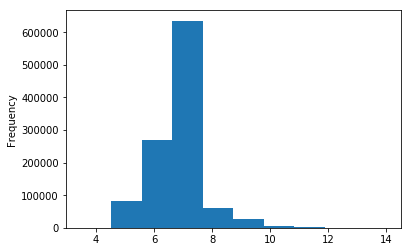

In [22]:
# plt.figure()
df.logShapeArea.plot.hist()